#### This notebook attempts to fit a Convolutional Neural Network over chest X-ray images.

In [55]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

    Define Constants.

In [11]:
BATCH_SIZE = 32
IMG_WIDTH = 224
IMG_HEIGHT = 224
EPOCHS = 25

    Data directories

In [12]:
train_dir = '../datasets/train'
test_dir = '../datasets/test'

    Perform Data augmentation for the training data

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

    Preprocess the test data in simple manner.

In [14]:
test_datagen = ImageDataGenerator(rescale=1./255)

    Get training images in batches using train_data generator.

In [15]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'  
)

Found 4173 images belonging to 2 classes.


    Get validation images in batches using validation generator.

In [16]:
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

Found 1043 images belonging to 2 classes.


    Define the CNN Architecture.

In [17]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

    Compile the CNN

In [20]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    Create an early_stopping Callback to prevent overfitting.

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    Train the model

In [22]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

Epoch 1/25
130/130 [==============================] - 163s 1s/step - loss: 0.5210 - accuracy: 0.7667 - val_loss: 0.3754 - val_accuracy: 0.8105
Epoch 2/25
130/130 [==============================] - 146s 1s/step - loss: 0.3607 - accuracy: 0.8298 - val_loss: 0.3339 - val_accuracy: 0.8330
Epoch 3/25
130/130 [==============================] - 140s 1s/step - loss: 0.2921 - accuracy: 0.8691 - val_loss: 0.3442 - val_accuracy: 0.8506
Epoch 4/25
130/130 [==============================] - 145s 1s/step - loss: 0.2831 - accuracy: 0.8785 - val_loss: 0.2760 - val_accuracy: 0.8730
Epoch 5/25
130/130 [==============================] - 138s 1s/step - loss: 0.2566 - accuracy: 0.8923 - val_loss: 0.2664 - val_accuracy: 0.8838
Epoch 6/25
130/130 [==============================] - 143s 1s/step - loss: 0.2386 - accuracy: 0.8983 - val_loss: 0.2867 - val_accuracy: 0.8701
Epoch 7/25
130/130 [==============================] - 136s 1s/step - loss: 0.2303 - accuracy: 0.9046 - val_loss: 0.2937 - val_accuracy: 0.8633

    Training Acc. VS Validation Acc.

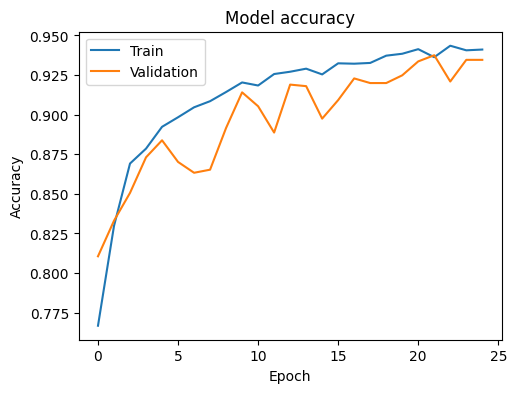

In [24]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

    Training Loss VS Validation Loss

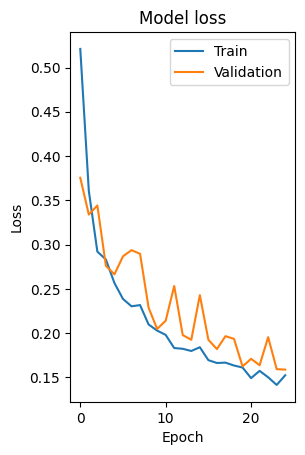

In [26]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

    Generate Test samples:

In [27]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  
)

Found 624 images belonging to 2 classes.


    Make Predictions

In [53]:
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps_per_epoch)
predicted_classes = np.where(predictions > 0.75, 1, 0).reshape(-1)
true_classes = test_generator.classes

20/20 [==============================] - 5s 236ms/step


In [54]:
report = classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices)
print(report)

              precision    recall  f1-score   support

      NORMAL       0.84      0.80      0.82       234
   PNEUMONIA       0.89      0.91      0.90       390

    accuracy                           0.87       624
   macro avg       0.86      0.86      0.86       624
weighted avg       0.87      0.87      0.87       624



    Let's plot the confusion matrix for the predicitons made:

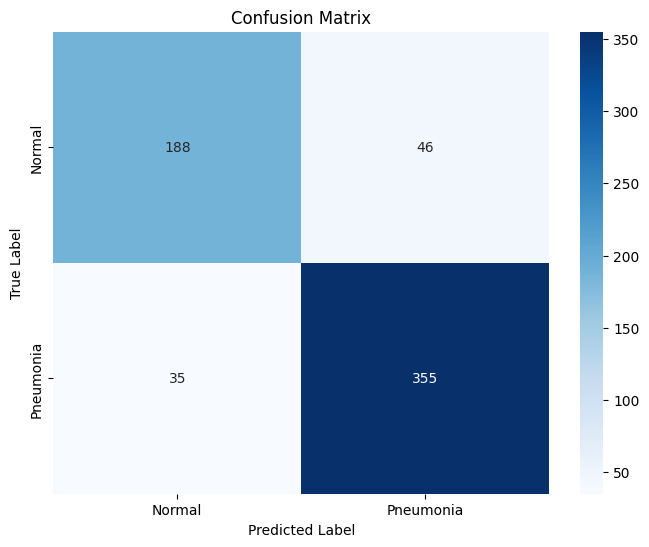

In [56]:
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()